# Support Vector Classifier (SVC) 
### Also known as Soft-Margin Classifier

In [2]:
import numpy as np
# Loss = (λ/2) * ||w||²  +  Σ max(0, 1 - y_i(w·x_i + b))
# if y * (w·x + b) < 1,  Gradient = (λ * w) - y * x
# if y * (w·x + b) >= 1,  Gradient = (λ * w)


class SupportVectorClassifier:
    """
    A Support Vector Classifier,
    a.k.a Linear Support Vector Machine,
    a.k.a Soft Margin Classifier
    trained via Stochastic Gradient Descent.
    """

    def __init__(self, n_epochs, lambda_param, decay_rate, initial_lr):
        self.n_epochs = n_epochs
        self.initial_lr = initial_lr # Learning Rate
        self.lambda_param = lambda_param  # Regularization parameter, like mu in class
        self.decay_rate = decay_rate # Learning Rate, Decay Rate
        self.w = None # Weights
        self.b = None # Bias

    def fit(self, X, y, batch_size=32):
        n_samples, n_features = X.shape
        # initialize weights
        self.w = np.zeros(n_features)
        self.b = 0
        self.loss_history = [] # To track loss for plotting

        # loop through data for n_epochs
        for epoch in range(self.n_epochs):
            
            # As epoch goes up, 1 + decay * epoch gets bigger, so lr gets smaller
            current_lr = self.initial_lr / (1 + self.decay_rate * epoch)
            
            # Shuffle data at each epoch
            # scrambles integers 0 - (n_samples - 1)
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            loss_this_epoch = 0  # gets updated once for each batch.

            for i in range(0, n_samples, batch_size):  # range(from, to, step_size)
                # batch_size of samples, and all features
                batch_X = X_shuffled[i:i + batch_size, :]
                batch_y = y_shuffled[i: i + batch_size]

                # Margin Calculation
                scores = np.dot(batch_X, self.w) + self.b  # scalar. Eta_i
                functional_margins = batch_y * scores  # vector
                # These samples contribute to hinge term in gradient
                violations = functional_margins < 1  # which samples violate margin
                
                # Gradient computations
                dw_reg_term = self.lambda_param * self.w
                dw_loss_term = np.dot(batch_y[violations],batch_X[violations]) / batch_size
                dw =  dw_reg_term - dw_loss_term
                db = -np.sum(batch_y[violations]) / batch_size # equal to np.dot(batch_y[mask], 1vector) / bacth_size
                
                # Update weights
                self.w -= current_lr * dw
                self.b -= current_lr * db
                
                # Compute and update Loss
                hinge_losses = np.maximum(0, 1 - functional_margins)  # vector
                loss_this_epoch += np.sum(hinge_losses)  # scalar

            # Track Loss
            reg_loss_term = self.lambda_param / 2 * np.dot(self.w, self.w)
            total_loss = reg_loss_term + loss_this_epoch / n_samples
            self.loss_history.append(total_loss)

    def get_score(self, X):
        # Computes side of decision boundary x lies on
        return np.dot(X, self.w) + self.b

    def predict(self, X):
        return np.sign(self.get_score(X))

# Ensemble of 10 One-vs-All SVCs

In [3]:

class OneVsAllSVC:
    """
    Wrapper to handle multi-class classification for MNIST (0-9).
    Trains 10 separate BinarySVCs.
    """

    def __init__(self, n_epochs, lambda_param, decay_rate, initial_lr = 0.1, batch_size = 32, classes = 10):
        self.n_epochs = n_epochs
        self.initial_lr = initial_lr # Learning Rate
        self.lambda_param = lambda_param # Regularization 
        self.batch_size = batch_size
        self.classes = classes
        self.decay_rate = decay_rate
        self.SVCs = []
        

    def fit(self, X, y):
        print(f'Training {self.classes} Support Vector Classifiers...')
        self.loss_histories = []
        
        for i in range(self.classes):
            ith_SVC = SupportVectorClassifier( # ith model
                n_epochs=self.n_epochs,
                initial_lr=self.initial_lr,
                lambda_param=self.lambda_param,
                decay_rate=self.decay_rate
                )
            # one vs all labeling
            y_vs_all = np.where(y == i, 1, -1) # if y == i, then label 1, else label -1
            ith_SVC.fit(X, y_vs_all, batch_size=self.batch_size)
            
            # save model and loss history 
            self.SVCs.append(ith_SVC)
            self.loss_histories.append(ith_SVC.loss_history)
            print(f'{i}th model trained')
            
            
    def predict(self, X):
        n_samples = X.shape[0]
        scores = np.zeros((n_samples, self.classes)) 
        
        for index, SVC in enumerate(self.SVCs): # for each weak learner SVC
            scores[:, index] = SVC.get_score(X) # store results
            
        return np.argmax(scores, axis =1) # axis=1 to compare across rows, each row is an observation
        
        
        

# Training and Evaluation

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load and Prepare Data
print(f'Loading MNIST Hand Written Digits data')
# as_frame=false returns a numpy array, not of a pandas DataFrame
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X = mnist.data # (70000, 784)
y = mnist.target.astype(int) # labels, 70000 of them
X = X / 255.0 # Normalize

# Test/Train split. X_train.shape = (56000, 784), X_test.shape = (14000, 784)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#### Set hyperparameters here

In [ ]:
# Training
epochs = 1
lambda_param = 0.0001
learning_rate_decay_rate = 0.05
model = OneVsAllSVC(n_epochs=epochs, lambda_param=lambda_param, decay_rate=learning_rate_decay_rate)
model.fit(X_train, y_train)
print('One-vs-All training complete')

# Plots!

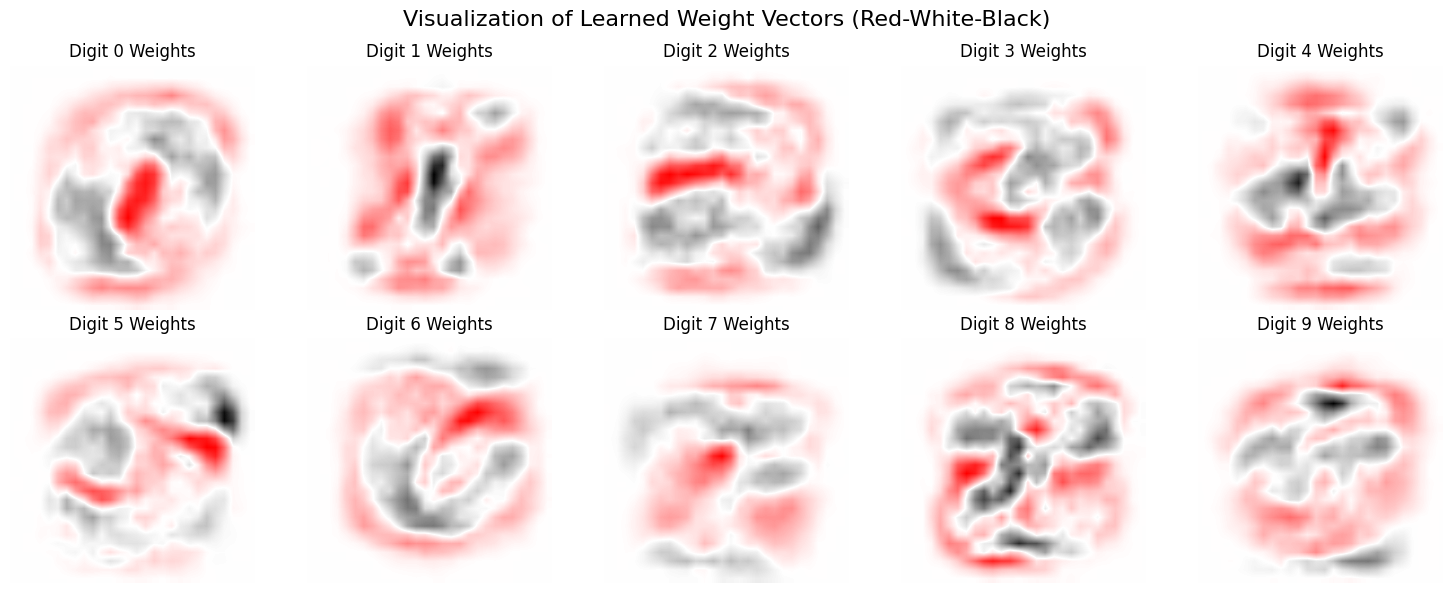

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


# --- Weight Visualization ("Ghost Digits") ---
# Colors: Red (negative) -> White (zero) -> Black (positive)
custom_cmap = LinearSegmentedColormap.from_list("red_white_black", ["red", "white", "black"])

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    # Reshape the 784 weights into a 28x28 image
    weight_img = model.SVCs[i].w.reshape(28, 28)
    
    # Fix vmin/vmax to ensure 0 is centered at white
    limit = max(abs(weight_img.min()), abs(weight_img.max()))
    
    im = ax.imshow(weight_img, cmap=custom_cmap, vmin=-limit, vmax=limit, interpolation='bilinear')
    ax.set_title(f'Digit {i} Weights')
    ax.axis('off')

plt.suptitle('Visualization of Learned Weight Vectors (Red-White-Black)', fontsize=16)
plt.tight_layout()
plt.show()
